In [1]:
import h2o

# Tuning Hyperparameters with Parallel Bayesian Optimization

*Kejia Shi, Aug 7, 2017*

This notebook demonstrates steps and results of using parallel Bayesian optimization to tune hyperparameters of a "real-life" GBM application. (Using `Boston` dataset) The main model is built using `h2o-3` and the optimization of hyperparameters is realized with `scikit-optimize`. Workflow mainly borrows from `scikit-optimize`.

### References

1. `h2o` 3.14 GBM documentation: http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html
2. `scikit-optimize` 0.4 documentation: https://scikit-optimize.github.io, 
Hyperparameter optimization https://github.com/scikit-optimize/scikit-optimize/blob/master/examples/hyperparameter-optimization.ipynb
3. Boston Dataset: http://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

## Settings

**Dataset:** The Boston Housing Dataset

This dataset contains information collected by the U.S Census Service concerning housing in the area of Boston Mass. It has been used extensively throughout the literature to benchmark algorithms. The dataset is small in size with only 506 cases and 14 attributes in each case of the dataset.

**Features:**

'CRIM': per capita crime rate by town

'ZN': proportion of residential land zoned for lots over 25,000 sq.ft

'INDUS': proportion of non-retail business acres per town

'CHAS': Charles River dummy variable (1 if tract bounds river; 0 otherwise)

'NOX': nitric oxides concentration (parts per 10 million)

'RM': average number of rooms per dwelling

'AGE': proportion of owner-occupied units built prior to 1940

'DIS': weighted distances to five Boston employment centres

'RAD': index of accessibility to radial highways

'TAX': full-value property-tax rate per $10,000

'PTRATIO': pupil-teacher ratio by town

'B': 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

'LSTAT': \% lower status of the population

'MEDV': Median value of owner-occupied homes in $1000's, censored at 50.00

**Model:**

Gradient Boosting Regression

## Load Dataset

In [2]:
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_77"; Java(TM) SE Runtime Environment (build 1.8.0_77-b03); Java HotSpot(TM) 64-Bit Server VM (build 25.77-b03, mixed mode)
  Starting server from /anaconda/lib/python2.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/ly/_ltwkx7n73q9s1xfz8720mvc0000gn/T/tmpD5TNCl
  JVM stdout: /var/folders/ly/_ltwkx7n73q9s1xfz8720mvc0000gn/T/tmpD5TNCl/h2o_KJ_started_from_python.out
  JVM stderr: /var/folders/ly/_ltwkx7n73q9s1xfz8720mvc0000gn/T/tmpD5TNCl/h2o_KJ_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.13.0.3981
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_KJ_gupw1x
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [3]:
boston_data = h2o.import_file(path="https://s3.amazonaws.com/h2o-public-test-data/smalldata/gbm_test/BostonHousing.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
boston_data.head

crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0.00632,18,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98,24
0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6
0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.9,5.33,36.2
0.02985,0,2.18,0,0.458,6.43,58.7,6.0622,3,222,18.7,394.12,5.21,28.7
0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.6,12.43,22.9
0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.9,19.15,27.1
0.21124,12.5,7.87,0,0.524,5.631,100,6.0821,5,311,15.2,386.63,29.93,16.5
0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.1,18.9


<bound method H2OFrame.head of >

## Default GBM

In [5]:
response = str(boston_data.names[-1])
features = [str(x) for x in boston_data.names[0:13]]

In [6]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm_default = H2OGradientBoostingEstimator(model_id = 'gbm_default', 
                                           seed = 1234)

gbm_default.train(x = features, 
                  y = response, 
                  training_frame = boston_data)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [7]:
gbm_default.model_performance(boston_data)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 2.94238551772
RMSE: 1.71533830999
MAE: 1.20988457472
RMSLE: 0.080945561612
Mean Residual Deviance: 2.94238551772


## GBM with Manual Cross Validation

In [8]:
# Build a GBM with manual settings and cross validation
gbm_manual_cv = H2OGradientBoostingEstimator(model_id = 'gbm_manual_cv', 
                                             seed = 1234,
                                             ntrees = 100,
                                             sample_rate = 0.9,
                                             col_sample_rate = 0.9,
                                             nfolds = 5)
                                            
gbm_manual_cv.train(x = features, 
                    y = response, 
                    training_frame = boston_data)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [9]:
# Check the cross validation model performance
gbm_manual_cv

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_manual_cv


ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1.62184091545
RMSE: 1.27351518069
MAE: 0.915035278901
RMSLE: 0.0626214063461
Mean Residual Deviance: 1.62184091545

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 9.68245835085
RMSE: 3.11166488409
MAE: 2.10682873026
RMSLE: 0.143431672337
Mean Residual Deviance: 9.68245835085
Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
mae,2.1077552,0.0988426,2.1354003,1.8475796,2.09966,2.2174108,2.2387254
mean_residual_deviance,9.7021475,1.5794705,8.983502,5.742834,11.1885,12.150076,10.4458275
mse,9.7021475,1.5794705,8.983502,5.742834,11.1885,12.150076,10.4458275
r2,0.8844405,0.0188984,0.9126117,0.9213600,0.8636847,0.8614832,0.8630633
residual_deviance,9.7021475,1.5794705,8.983502,5.742834,11.1885,12.150076,10.4458275
rmse,3.0912576,0.2704387,2.9972491,2.3964212,3.3449216,3.4856958,3.2320006
rmsle,0.1420960,0.0156690,0.1539993,0.1103884,0.1344691,0.1767126,0.1349108


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
,2017-08-15 12:39:31,1.037 sec,0.0,9.1880116,6.6472074,84.4195565
,2017-08-15 12:39:31,1.041 sec,1.0,8.4315038,6.1072998,71.0902566
,2017-08-15 12:39:31,1.044 sec,2.0,7.7557877,5.6170229,60.1522428
,2017-08-15 12:39:31,1.046 sec,3.0,7.1567843,5.1821106,51.2195620
,2017-08-15 12:39:31,1.048 sec,4.0,6.6222758,4.7974335,43.8545367
---,---,---,---,---,---,---
,2017-08-15 12:39:31,1.293 sec,96.0,1.3025699,0.9353475,1.6966884
,2017-08-15 12:39:31,1.295 sec,97.0,1.2981069,0.9327798,1.6850815
,2017-08-15 12:39:31,1.298 sec,98.0,1.2893704,0.9256475,1.6624760
,2017-08-15 12:39:31,1.300 sec,99.0,1.2804204,0.9176468,1.6394764



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
rm,92194.5312500,1.0,0.4329475
lstat,77640.5234375,0.8421381,0.3646016
dis,9081.6787109,0.0985056,0.0426478
nox,8091.0268555,0.0877604,0.0379956
crim,6473.8496094,0.0702195,0.0304013
age,6391.3251953,0.0693243,0.0300138
ptratio,3893.0029297,0.0422260,0.0182816
indus,3367.7416992,0.0365286,0.0158150
tax,2713.4658203,0.0294320,0.0127425
b,1875.7456055,0.0203455,0.0088085


## GBM with hyperparameters tuned by `scikit-optimize`

In [11]:
# Show no progress bar
h2o.no_progress()

In [12]:
def objective(params):
    # Ensure right parameters to be tuned
    max_depth, learn_rate, min_rows = params

    # Create such model with given hyperparameters
    gbm_skopt_cv = H2OGradientBoostingEstimator(model_id = 'gbm_manual_cv',
                                                seed = 1234,
                                                ntrees = 100,
                                                sample_rate = 0.9,
                                                col_sample_rate = 0.9,
                                                nfolds = 5,
                                                max_depth = max_depth,
                                                learn_rate = learn_rate,
                                                min_rows = min_rows)

    # Build the gradient boosting regression model
    gbm_skopt_cv.train(x = features,
                       y = response,
                       training_frame = boston_data)

    # Return specific optimization matric value
    # Here: cross validation mean absolute error
    return gbm_skopt_cv.cross_validation_metrics_summary().as_data_frame().iloc[[0]]['mean'].as_matrix().astype(float).item()

In [13]:
# Test if our objective function performs well
objective((5, 0.1, 50))

2.608365

In [14]:
# Set hyperparameter search space
space  = [(1, 5),                           # max_depth
          (10**-5, 10**0, "log-uniform"),   # learn_rate
          (1, 100)]                         # min_row

Default of `skopt` uses `cl_min`, constant liar (min) parallel strategy. Acquisition function is chosen to be `EI` and uses the `L-BFGS` method on the likelihood objective. We print out the best score and parameter setting of optimizing the Mean Absolute Error of this 5-fold Cross Validation.

In [15]:
from skopt import gp_minimize

res_gp = gp_minimize(objective, space, n_calls=100, random_state=0,
                     acq_func="EI", acq_optimizer="lbfgs")

"Best score=%.4f" % res_gp.fun

'Best score=1.9559'

In [16]:
print("""Best parameters:
- max_depth=%d
- learn_rate=%.6f
- min_rows=%d""" % (res_gp.x[0], res_gp.x[1], 
                    res_gp.x[2]))

Best parameters:
- max_depth=4
- learn_rate=0.083958
- min_rows=1


Very same setting of PI gives "Best score=2.0034".

## Draw Convergence Plot

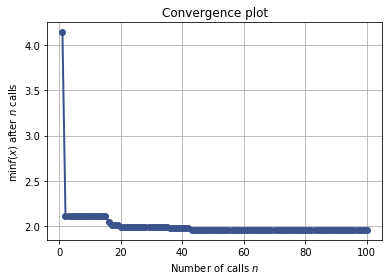

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from skopt.plots import plot_convergence

plot_convergence(res_gp);

In [3]:
h2o.cluster().shutdown()

H2O session _sid_bba9 closed.
